<a href="https://colab.research.google.com/github/ankalagigaurave/AI_SemV/blob/master/Labs/Lab%201/DL_Lab_1_J004_Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf '/content/flowers'
!rm flowers-new.zip

rm: cannot remove 'flowers-new.zip': No such file or directory


In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.callbacks import EarlyStopping,ModelCheckpoint 

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [3]:
#Getting the dataset
!wget http://upscfever.com/datasets/flowers-new.zip
#Unzipping the dataset
!unzip -q flowers-new.zip #-q is specified to remove the info displayed for each image

--2020-12-11 01:42:27--  http://upscfever.com/datasets/flowers-new.zip
Resolving upscfever.com (upscfever.com)... 104.27.176.133, 172.67.193.2, 104.27.177.133, ...
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/flowers-new.zip [following]
--2020-12-11 01:42:28--  https://upscfever.com/datasets/flowers-new.zip
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘flowers-new.zip’

flowers-new.zip         [          <=>       ]   5.74M  2.55MB/s    in 2.2s    

2020-12-11 01:42:33 (2.55 MB/s) - ‘flowers-new.zip’ saved [6021364]



In [4]:
#Defining a function to generate more data with slight variations for training
def gen_data(flower):
  label = flower
  path = '/content/flowers/' + flower
  img_list = os.listdir(path)
  for img in img_list:
    img = cv2.imread(path + '/' + img)
    img = img.reshape((1,) + img.shape) 

    augment = ImageDataGenerator(rescale = 1./255, zoom_range = 0.1, 
                             height_shift_range = 0.1, shear_range = 5, rotation_range = 5,
                             horizontal_flip = True)

    i = 0
    for batch in augment.flow(img, batch_size = 1, save_to_dir = path + '/', save_prefix = 'gen', 
                        save_format = 'jpeg'):
      i = i+1
      if i == 20: break

In [5]:
#Defining a function to compile our dataset since our data is in different folders
x = []
y = []
def compile_data(flower):
  label = flower
  path = '/content/flowers/' + flower
  img_list = os.listdir(path)
  for img in img_list:
    img = cv2.imread(path + '/' + img)
    img = cv2.resize(img, (150, 150))
    x.append(img)
    y.append(label)

In [6]:
#Generating more data for each flower
gen_data('daisy')
gen_data('dandelion')
gen_data('rose')
gen_data('sunflower')
gen_data('tulip')

In [7]:
#Compiling all the data
compile_data('daisy')
compile_data('dandelion')
compile_data('rose')
compile_data('sunflower')
compile_data('tulip')

In [8]:
#Converting all the images into NumPy Array, Reshaping then Scaling
x = np.array(x)
x = np.reshape(x, (len(x), 150*150*3))
x = x/255
np.shape(x)

(2393, 67500)

In [9]:
#Converting all the flowers into labels
LE = LabelEncoder()
y = LE.fit_transform(y)
y = to_categorical(y)
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [11]:
y_test.shape

(599, 5)

In [12]:
y_train.shape

(1794, 5)

In [13]:
np.random.seed(42)
rn.seed(42)


In [14]:
flower_ann = Sequential()
flower_ann.add(Dense(1024, activation="relu",input_shape=(150*150*3,)))
flower_ann.add(Dense(512, activation="relu"))
flower_ann.add(Dense(128, activation="relu"))
flower_ann.add(Dense(64, activation="relu"))
flower_ann.add(Dense(5, activation="softmax"))

flower_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              69121024  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 69,720,069
Trainable params: 69,720,069
Non-trainable params: 0
_________________________________________________________________


In [15]:
flower_ann.compile(optimizer="adam",
           loss='categorical_crossentropy',
           metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [16]:
history = flower_ann.fit(x_train,y_train, epochs=100, batch_size = 100, validation_split=0.25, verbose=2,callbacks=[es,mc])

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.27617, saving model to best_model.h5
14/14 - 4s - loss: 27.2538 - accuracy: 0.2193 - val_loss: 18.3470 - val_accuracy: 0.2762
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.27617
14/14 - 1s - loss: 14.6912 - accuracy: 0.2721 - val_loss: 5.5522 - val_accuracy: 0.2584
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.27617 to 0.43430, saving model to best_model.h5
14/14 - 11s - loss: 3.3653 - accuracy: 0.3717 - val_loss: 2.6509 - val_accuracy: 0.4343
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.43430 to 0.53898, saving model to best_model.h5
14/14 - 17s - loss: 1.4963 - accuracy: 0.5472 - val_loss: 1.1622 - val_accuracy: 0.5390
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.53898 to 0.54566, saving model to best_model.h5
14/14 - 22s - loss: 1.3518 - accuracy: 0.5584 - val_loss: 1.2072 - val_accuracy: 0.5457
Epoch 6/100

Epoch 00006: val_accuracy improved from 0.54566 to 0.57016, saving mo

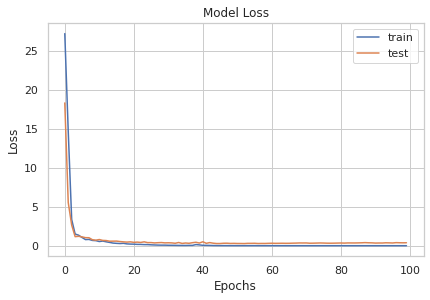

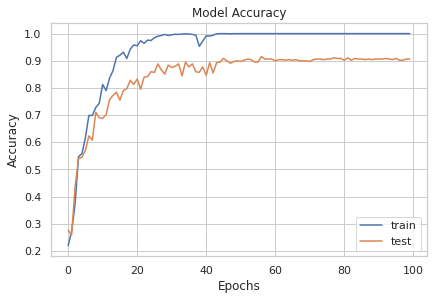

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [19]:
x = np.reshape(x, (np.shape(x)[0], 150, 150, 3))

In [20]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [21]:
flower_cnn = Sequential()
flower_cnn.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='linear', input_shape = (150,150,3)))
flower_cnn.add(MaxPooling2D(pool_size=(2,2)))


flower_cnn.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='linear'))
flower_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

flower_cnn.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='linear'))
flower_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

flower_cnn.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
flower_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

flower_cnn.add(Flatten())
flower_cnn.add(Dense(512))
flower_cnn.add(Activation('relu'))
flower_cnn.add(Dense(5, activation = "softmax"))

In [22]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [23]:
flower_cnn.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
flower_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)       

In [25]:
History = flower_cnn.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test), 
                              verbose = 1)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
15/15 [==============================] - 2s 138ms/step - loss: 1.2362 - accuracy: 0.4922 - val_loss: 1.2105 - val_accuracy: 0.5559
Epoch 2/50
15/15 [==============================] - 2s 101ms/step - loss: 0.9692 - accuracy: 0.6672 - val_loss: 0.6077 - val_accuracy: 0.7613
Epoch 3/50
15/15 [==============================] - 2s 101ms/step - loss: 0.5346 - accuracy: 0.7904 - val_loss: 0.7238 - val_accuracy: 0.7162
Epoch 4/50
15/15 [==============================] - 1s 100ms/step - loss: 0.5331 - accuracy: 0.8149 - val_loss: 0.3691 - val_accuracy: 0.8681
Epoch 5/50
15/15 [==============================] - 2s 100ms/step - loss: 0.2477 - accuracy: 0.9147 - val_loss: 0.6708 - val_accuracy: 0.7997
Epoch 6/50
15/15 [==============================] - 1s 100ms/step - loss: 0.7539 - accuracy: 0.7809 - val_loss: 0.5152 - val_accuracy: 0.8080
Epoch 7/50
15/15 [==============================] - 2s 100ms/step - loss: 0.3411 - accuracy: 0.8813 - val_loss: 0.2128 - val_accuracy: 0.9098
Epoch 

In [26]:
predictions = flower_cnn.predict(x_test)
predictions = np.argmax(predictions,axis = 1)

In [27]:
y_test_ = to_categorical(y_test)
predictions = to_categorical(predictions,5)

a = np.argmax(predictions ,axis=1)
a

array([1, 0, 3, 4, 4, 1, 4, 3, 3, 4, 1, 3, 3, 1, 1, 1, 4, 1, 2, 3, 2, 3,
       4, 0, 3, 1, 4, 4, 3, 2, 3, 3, 1, 0, 1, 3, 1, 3, 4, 3, 4, 2, 0, 2,
       1, 2, 4, 1, 2, 2, 2, 0, 4, 0, 3, 3, 2, 4, 1, 4, 4, 2, 2, 2, 4, 1,
       2, 2, 1, 0, 0, 3, 4, 3, 2, 4, 4, 1, 2, 1, 4, 3, 2, 1, 2, 2, 0, 0,
       1, 0, 1, 4, 2, 3, 2, 1, 4, 2, 4, 1, 2, 2, 3, 4, 4, 3, 0, 1, 2, 2,
       3, 1, 2, 3, 1, 1, 3, 1, 0, 3, 4, 3, 1, 4, 2, 2, 2, 4, 1, 2, 1, 4,
       3, 1, 2, 4, 1, 3, 4, 2, 2, 4, 4, 3, 3, 3, 1, 1, 3, 0, 4, 1, 2, 3,
       4, 1, 4, 1, 3, 4, 2, 0, 4, 3, 0, 2, 2, 3, 3, 3, 4, 1, 4, 0, 3, 4,
       3, 0, 2, 1, 2, 3, 4, 2, 3, 1, 0, 4, 3, 2, 1, 2, 0, 0, 1, 3, 2, 2,
       0, 3, 2, 4, 3, 2, 1, 3, 2, 0, 2, 3, 2, 3, 4, 1, 3, 3, 1, 1, 1, 1,
       3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 1, 3, 0, 0, 2, 4, 4, 4, 2, 2, 1, 1,
       1, 1, 4, 3, 0, 3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 0, 0, 2, 0, 4, 1, 1,
       4, 0, 3, 3, 3, 2, 2, 1, 2, 4, 4, 3, 3, 3, 2, 4, 0, 0, 2, 4, 0, 3,
       4, 3, 4, 3, 1, 2, 0, 4, 4, 1, 1, 3, 3, 1, 2,

In [28]:
b = np.argmax(y_test ,axis=1)
b

array([1, 0, 3, 4, 4, 1, 4, 3, 3, 4, 1, 3, 3, 1, 1, 1, 4, 1, 2, 3, 2, 3,
       4, 0, 3, 1, 4, 4, 3, 2, 3, 3, 1, 0, 1, 3, 1, 3, 4, 3, 4, 2, 0, 2,
       1, 2, 4, 1, 2, 2, 2, 0, 4, 0, 3, 3, 2, 4, 1, 4, 4, 2, 2, 2, 4, 1,
       2, 2, 1, 0, 0, 3, 4, 3, 2, 4, 4, 1, 2, 1, 4, 3, 2, 1, 2, 2, 0, 0,
       1, 0, 1, 4, 2, 3, 2, 1, 4, 2, 4, 1, 2, 2, 3, 4, 4, 3, 0, 1, 2, 2,
       3, 1, 2, 3, 1, 1, 3, 1, 0, 3, 4, 3, 1, 4, 2, 2, 2, 4, 1, 2, 1, 4,
       3, 1, 2, 4, 1, 3, 4, 2, 2, 4, 4, 3, 3, 3, 1, 1, 3, 0, 4, 1, 2, 3,
       4, 1, 4, 1, 3, 4, 2, 0, 4, 3, 0, 2, 2, 3, 3, 3, 4, 1, 4, 0, 3, 4,
       3, 0, 2, 1, 2, 3, 4, 2, 3, 1, 0, 4, 3, 2, 1, 2, 0, 0, 1, 3, 2, 2,
       0, 3, 2, 4, 3, 2, 1, 3, 2, 0, 2, 3, 2, 3, 4, 1, 3, 3, 1, 1, 1, 1,
       3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 1, 3, 0, 0, 2, 4, 4, 4, 2, 2, 1, 1,
       1, 1, 4, 3, 0, 3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 0, 0, 2, 0, 4, 1, 1,
       4, 0, 3, 3, 3, 2, 2, 1, 2, 4, 4, 3, 3, 3, 2, 4, 0, 0, 2, 2, 0, 3,
       4, 3, 4, 3, 1, 2, 0, 4, 4, 1, 1, 3, 3, 1, 2,

In [29]:
cm = confusion_matrix(a,b)
cm

array([[ 65,   0,   0,   0,   0],
       [  0, 142,   0,   0,   0],
       [  0,   0, 130,   0,   1],
       [  0,   0,   0, 138,   0],
       [  0,   1,   2,   0, 120]])

In [30]:
accuracy = sum(cm[i][i] for i in range(5)) / y_test.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.993322203672788


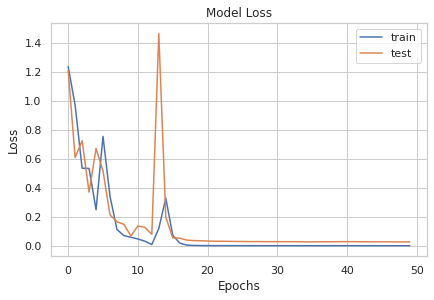

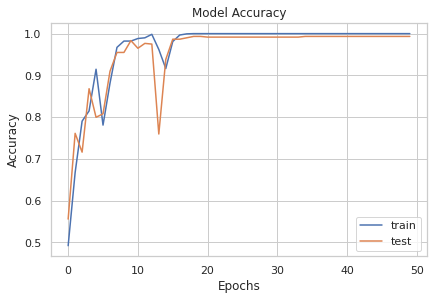

In [32]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()